# Нейронная сеть, которая решает задачу классификации

- чтобы эксперименты были воспроизводимы фиксируется сид (номер начала случайной последовательности из которой будут браться "случайные" числа)
- библиотека cudnn может выполняться в детерминистичном режиме, а может в недетерминистичном. Недетерминистичный режим гораздо быстрее, но если мы действительно, в угоду скорости, хотим детерминистичность, хотим, чтобы была воспроизводимость, то нам нужно выставить этот параметр в "True". 

In [2]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

- датасет

In [3]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [6]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

- все подвыборки (фолды) обернем в тензоры
  - вещественные и целые

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],   # возьмем только 2 первых предиктора Alcohol, Malic acid (чтоб потом нарисовать)
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

- сеть трехслойная
- количество входов - по количеству предикторов
- количество выходов - по количеству классов

в режиме обучения (`forward`) выдает абсолютные значения некоторых признаков
- почему? потому что функция потерь - кроссэнтропия, и ей не нужен софтмакс, у нее и так логарифмы
  - по идее это зависит от конкретной реализации кросс-энтропии (в торче так)
- т.е. если мы хотим просто считать лоссы, нам softmax не нужен. Если
- если хотим посчитать вероятности, то нам придётся использовать softmax.

в режиме предсказания - выход оборачиваются в софтмакс
- тут нам конкретно вероятности нужны

In [11]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        """Sigmoid(Sigmoid(X*W1+b1) * W2 + b2) * W3 + b3)"""
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        """Softmax(Sigmoid(Sigmoid(X*W1+b1) * W2 + b2) * W3 + b3))"""
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

In [12]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

Обучение минибатчами

- при расчете метрики на тесте также не обязательно брать софтмакс для класса, если нас интересует самый вероятный класс, а не распределение в целом - в этом случае просто взять максимум выхода достаточно

In [16]:
np.random.permutation(5)    # некоторая перестановка индексов

array([1, 2, 4, 3, 0])

In [17]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train))                         # порядок перемененного датасета
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]       # индексты элементов батча
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch)                               # без софтмакса, просто выходы нейронов (логиты)
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:                                                # метрики на тесте
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)                           # максимальный 
        print((test_preds == y_test).float().mean())                    # точность (доля верных классов)

tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)


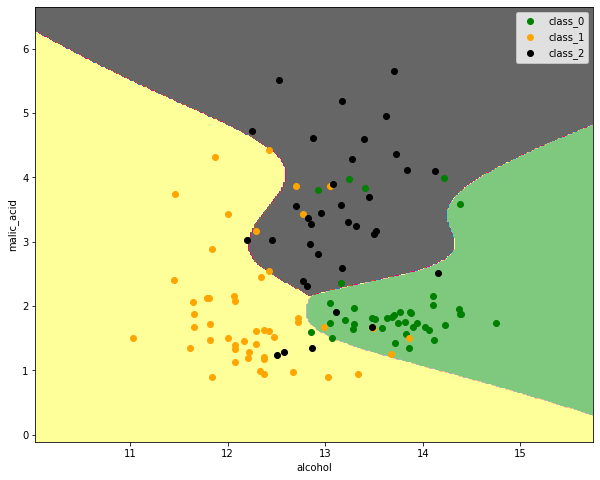

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step), 
                         indexing='ij')

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

## Виузализация полученных кластеров

- тут не интересно, т.к. и так 2д данные

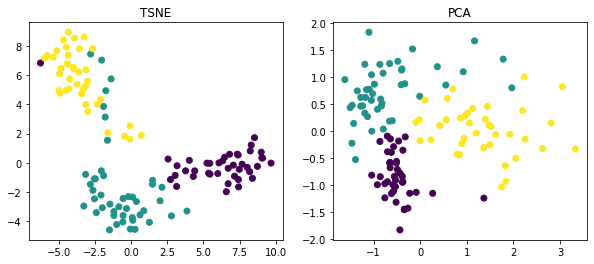

In [44]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pred_classes = wine_net.forward(X_train).detach().numpy().argmax(axis=1)

tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate="auto")
df_tsne = tsne.fit_transform(X_train)

pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(X_train)
    

plt.figure(figsize=(10, 4))

ax0 = plt.subplot(1, 2, 1)
ax0.set_title("TSNE")
ax0.scatter(df_tsne[:,0], df_tsne[:,1], c=pred_classes)

ax1 = plt.subplot(1, 2, 2)
ax1.set_title("PCA")
ax1.scatter(df_pca[:,0], df_pca[:,1], c=pred_classes)

plt.show()

Наша нейросеть – это сложная функция от входов, параметризованная весами и смещениями (bias). Давайте разберемся, как выглядит ее аналитический вид:

Возьмем первый полносвязный слой (`torch.nn.Linear`). Он принимает на вход вектор одного объекта $\vec{x}$ из $k$ чисел. В нашем случае у объекта 2 признака, значит $k=2$. Сам слой содержит `n_hidden_neurons`. У каждого нейрона этого слоя $k$ весов (по одному весу на вход) и по одному значению bias. Каждый нейрон отдает 1 число: таким образом, выход слоя – это вектор из n чисел.

Функцию полносвязного слоя можно представить в виде матричного перемножения $\vec{x}$ и матрицы весов всех нейронов слоя, где один нейрон отвечает одному столбцу в матрице:

<img src="../img/fcgemm_corrected.png" width="500">

При этом нужно не забыть про bias. Один из способов его учесть: расширить $\vec{x}$, добавив к нему 1 в качестве последнего значения. В таком случае, bias будет просто одним из весов, который всегда умножается на 1. На картинке выше значения bias'ов будут находится в последней строчке матрицы весов.

Получается, формула для вычисления выходов из первого слоя выглядит следующим образом:

$$\begin{bmatrix} z_{1} & z_{2} & z_{3} & \dots & z_{n} \end{bmatrix} = \begin{bmatrix} x_{1} & x_{2} & \dots & x_{k} & 1 \end{bmatrix} \begin{bmatrix} w_1^1 & w_1^2 & w_1^3 & \dots & w_1^n \\ w_2^1 & w_2^2 & w_2^3 & \dots & w_2^n \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ w_k^1 & w_k^2 & w_k^3 & \dots & w_k^n \\ b^1 & b^2 & b^3 & \dots & b^n \\ \end{bmatrix}$$ 

Кроме того, мы можем посчитать выходы сразу для нескольких объектов, если вместо одного элемента $\vec{x}$ подадим сразу матрицу из $m$ элементов, где каждая строчка будет отвечать за конкретный вектор входа:  

$$\begin{bmatrix} z_1^1 & z_1^2 & z_1^3 & \dots & z_1^n \\ z_2^1 & z_2^2 & z_2^3 & \dots & z_2^n \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ z_m^1 & z_m^2 & z_m^3 & \dots & z_m^n \\ \end{bmatrix} = \begin{bmatrix} x_1^1 & x_1^2 & x_1^3 & \dots & x_1^k & 1\\ x_2^1 & x_2^2 & x_2^3 & \dots & x_2^k & 1\\ \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\ x_m^1 & x_m^2 & x_m^3 & \dots & x_m^k & 1\\ \end{bmatrix} \begin{bmatrix} w_1^1 & w_1^2 & w_1^3 & \dots & w_1^n \\ w_2^1 & w_2^2 & w_2^3 & \dots & w_2^n \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ w_k^1 & w_k^2 & w_k^3 & \dots & w_k^n \\ b^1 & b^2 & b^3 & \dots & b^n \\ \end{bmatrix}$$ 

Выходы слоя мы передадим в функцию $\sigma (z)={\frac {1}{1+e^{-z}}}$, которая будет применена для каждого элемента результирующей матрицы $z_i^j$. Далее эти выходы можно передать в следующий слой, аналогично тому, как мы сделали с матрицей $X$. К матрице выходов из последнего слоя можно применить функцию Softmax. Softmax применится построчно (в видео мы для этого выставили параметр dim=1) и преобразует выходы из нейронов в "вероятности".

Запишите в одну строчку формулу функции inference для сети WineNet.

    Softmax(Sigmoid(Sigmoid(X*W1+b1) * W2 + b2) * W3 + b3))

# Что имеет смысл улучшить / пошевелить

- использовать больше скрытых нейронов
- количество скрытых слоев (столько тут не нужно)
- оптимизатор
- шаг обучения
- вид функции активации


Измените архитектуру так, чтобы на вход принимались все 13 признаков и проведите следующие эксперименты:

1. Поэкспериментируйте с количеством нейронов в скрытых слоях. Попробуйте поставить очень маленькое число. Существует ли пороговое значение количества скрытых нейронов, при котором обучение становится невозможным?

2. Попробуйте передавать различные значения test_size в функцию train_test_split. При каком значении test_size сеть предсказывает хуже чем Base Rate*? И какой Base Rate у датасета вин?

3. Зависит ли время обучения на одной эпохе от размера батча? Исследуйте эту зависимость.



In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    wine.data,
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [49]:
X_train.shape

torch.Size([124, 13])

In [54]:
class WineNet(torch.nn.Module):
    def __init__(self, n_features, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(n_features, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

n_features = X_train.shape[-1]
wine_net = WineNet(n_features, 10)

In [55]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [56]:
batch_size = 10

for epoch in range(1000):
    order = np.random.permutation(len(X_train))                         # порядок перемененного датасета
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]       # индексты элементов батча
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch)                               # без софтмакса, просто выходы нейронов (логиты)
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:                                                # метрики на тесте
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)                           # максимальный 
        print((test_preds == y_test).float().mean())                    # точность (доля верных классов)

tensor(0.3333)
tensor(0.8333)


/home/user1/envs/py310/lib64/python3/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


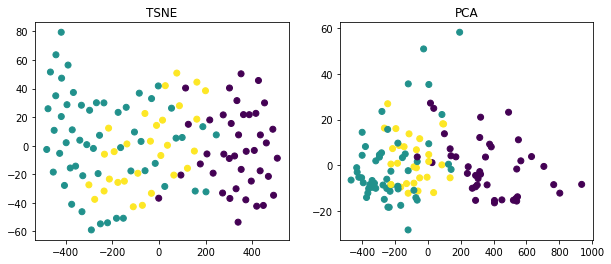

In [58]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pred_classes = wine_net.forward(X_train).detach().numpy().argmax(axis=1)

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate="auto")
df_tsne = tsne.fit_transform(X_train)

pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(X_train)
    

plt.figure(figsize=(10, 4))

ax0 = plt.subplot(1, 2, 1)
ax0.set_title("TSNE")
ax0.scatter(df_tsne[:,0], df_tsne[:,1], c=pred_classes)

ax1 = plt.subplot(1, 2, 2)
ax1.set_title("PCA")
ax1.scatter(df_pca[:,0], df_pca[:,1], c=pred_classes)

plt.show()